In [2]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 22.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [folium]2m3/4 [folium]


In [4]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.1 MB/s  0:00:00eta 0:00:01


In [6]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 19.0 MB/s  0:00:00 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 20.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 20.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from math import radians, sin, cos, sqrt, asin

# 1. Cargar resultados
rutas = pd.read_csv("rutas_caso3_clean.csv")
clients = pd.read_csv("clients_clean.csv")
depots = pd.read_csv("depots_clean.csv")
vehicles = pd.read_csv("vehicles_clean.csv")

# 2. Unir coordenadas para calcular distancias
coords = {r["StandardizedID"]: (r["Latitude"], r["Longitude"]) for _, r in clients.iterrows()}
coords.update({r["StandardizedID"]: (r["Latitude"], r["Longitude"]) for _, r in depots.iterrows()})

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0088
    dphi = radians(lat2 - lat1)
    dlmb = radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlmb/2)**2
    return 2*R*asin(sqrt(a))

# Calcular distancias
rutas["Distance_km"] = rutas.apply(
    lambda r: haversine(*coords[r["From"]], *coords[r["To"]]), axis=1
)


In [8]:
m = folium.Map(location=[clients["Latitude"].mean(), clients["Longitude"].mean()], zoom_start=11)

# Agregar CDs
for _, row in depots.iterrows():
    folium.Marker(
        [row["Latitude"], row["Longitude"]],
        popup=f'Depot {row["StandardizedID"]}',
        icon=folium.Icon(color='red', icon='warehouse', prefix='fa')
    ).add_to(m)

# Agregar rutas por vehículo
for v in rutas["VehicleID"].unique():
    dfv = rutas[rutas["VehicleID"] == v]
    for _, r in dfv.iterrows():
        folium.PolyLine(
            [coords[r["From"]], coords[r["To"]]], color='blue', weight=2, opacity=0.7
        ).add_to(m)

m.save("mapa_caso3.html")


In [9]:
import pandas as pd
import math

# Cargar archivos
rutas = pd.read_csv("rutas_caso3_clean.csv")
clients = pd.read_csv("clients_clean.csv")
depots = pd.read_csv("depots_clean.csv")
vehicles = pd.read_csv("vehicles_clean.csv")

# Crear diccionario de coordenadas
coords = {r["StandardizedID"]: (r["Latitude"], r["Longitude"]) for _, r in clients.iterrows()}
coords.update({r["StandardizedID"]: (r["Latitude"], r["Longitude"]) for _, r in depots.iterrows()})

# Distancia Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# Calcular distancias de cada arco
rutas["Distance_km"] = rutas.apply(
    lambda r: haversine(*coords[r["From"]], *coords[r["To"]]), axis=1
)

rutas.head()


,VehicleID,From,To,Distance_km
0,V001,C013,CD01,14.890101
1,V001,C018,C036,2.810846
2,V001,C027,C040,12.302795
3,V001,C036,C027,6.065031
4,V001,C040,C013,9.761312


In [10]:
# Parámetros económicos
C_dist = 2500     # Costo por km
speed = 30        # km/h

# Agrupar por vehículo
vehicle_summary = rutas.groupby("VehicleID").agg(
    TotalDistance_km = ("Distance_km", "sum"),
    NumberOfArcs = ("Distance_km", "count")
).reset_index()

vehicle_summary["TravelTime_hours"] = vehicle_summary["TotalDistance_km"] / speed
vehicle_summary["Cost_distance"] = vehicle_summary["TotalDistance_km"] * C_dist

vehicle_summary


,VehicleID,TotalDistance_km,NumberOfArcs,TravelTime_hours,Cost_distance
0,V001,64.062167,6,2.135406,160155.416272
1,V002,9.009773,2,0.300326,22524.433718
2,V003,50.861803,5,1.695393,127154.508402
3,V004,43.421029,3,1.447368,108552.571610
4,V005,42.028482,3,1.400949,105071.204250
5,V006,56.006498,4,1.866883,140016.244395
6,V007,17.556981,2,0.585233,43892.451334
7,V009,39.753318,3,1.325111,99383.296085
8,V010,35.026101,5,1.167537,87565.251723
9,V011,54.804930,4,1.826831,137012.325966


In [11]:
import numpy as np

mean_dist = vehicle_summary["TotalDistance_km"].mean()
std_dist = vehicle_summary["TotalDistance_km"].std()

mean_time = vehicle_summary["TravelTime_hours"].mean()
std_time = vehicle_summary["TravelTime_hours"].std()

print("Distancia promedio por vehículo:", mean_dist)
print("Desviación estándar:", std_dist)

print("Tiempo promedio por vehículo:", mean_time)
print("Desviación estándar:", std_time)

print("Vehículos utilizados:", len(vehicle_summary))
print("Distancia total:", vehicle_summary["TotalDistance_km"].sum())
print("Costo total estimado:", vehicle_summary["Cost_distance"].sum())


Distancia promedio por vehículo: 44.914198357769436
Desviación estándar: 17.742058902437
Tiempo promedio por vehículo: 1.4971399452589818
Desviación estándar: 0.5914019634145666
Vehículos utilizados: 33
Distancia total: 1482.1685458063914
Costo total estimado: 3705421.364515979


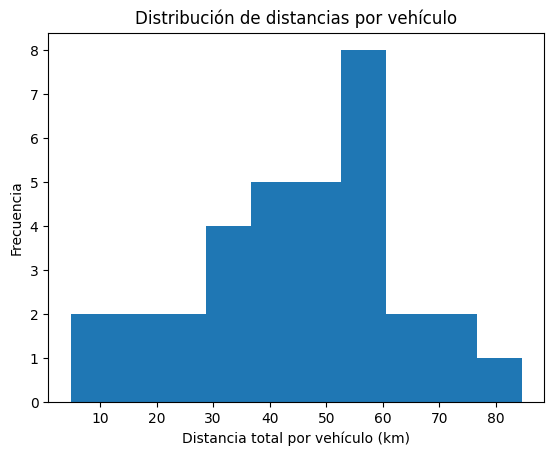

In [12]:
import matplotlib.pyplot as plt

plt.hist(vehicle_summary["TotalDistance_km"], bins=10)
plt.xlabel("Distancia total por vehículo (km)")
plt.ylabel("Frecuencia")
plt.title("Distribución de distancias por vehículo")
plt.show()


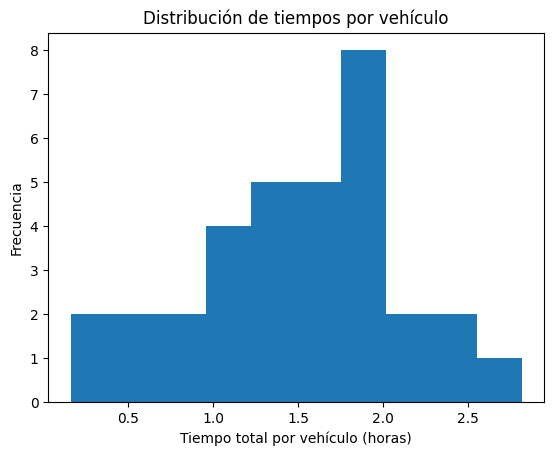

In [13]:
plt.hist(vehicle_summary["TravelTime_hours"], bins=10)
plt.xlabel("Tiempo total por vehículo (horas)")
plt.ylabel("Frecuencia")
plt.title("Distribución de tiempos por vehículo")
plt.show()
